In [2]:
import numpy as np
import math
import bisect
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import integrate
from itertools import accumulate

# For Interactive Features
from ipywidgets import interact, FloatSlider, IntSlider
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

def log_formatter(x, pos):
    return f"{10**x:.0f}"

# Model Schemes and Set of ODEs

## Model 1

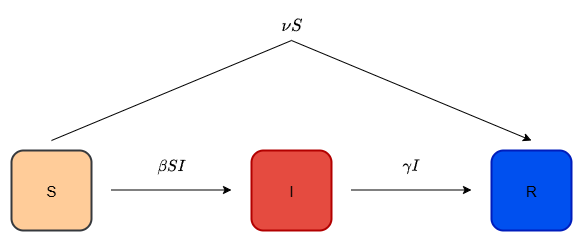

$$
\begin{aligned}
\frac{dS}{dt} &= -\beta S I - \nu S \\
\frac{dI}{dt} &= \beta S I - \gamma I \\
\frac{dR}{dt} &= \gamma I + \nu S
\end{aligned}
$$

Here, $\nu$ is the **vaccination rate**, proportion of population getting vaccinated per unit time, assumed to be a constant for simplicity.


In [6]:
# Model 1 Definition
def sir_vacc_model1(y, t, pars):
    S = y[0]
    I = y[1]
    
    dSdt = -pars['beta'] * S * I - pars['v'] * S
    dIdt = pars['beta'] * S * I - pars['gamma'] * I
    dRdt = pars['gamma'] * I + pars['v'] * S
    dydt = [dSdt, dIdt, dRdt]
    return dydt

## Model 1 - Variant

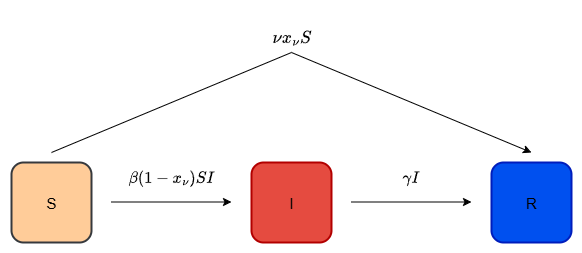

$$
\begin{aligned}
\frac{dS}{dt} &= -\beta (1-x_\nu) S I - \nu x_\nu S \\
\frac{dI}{dt} &= \beta (1-x_\nu) S I - \gamma I \\
\frac{dR}{dt} &= \gamma I + \nu x_\nu S
\end{aligned}
$$

Here, $x_\nu$ is the **proportion of population ready to get vaccinated**, indicating preparedness(?) OR accessibility(?) of the vaccination, assumed to be a constant for simplicity.

In [9]:
# Model 1 Variant Definition
def sir_vacc_model1_var(y, t, pars):
    S = y[0]
    I = y[1]
    
    dSdt = -pars['beta'] * (1-pars['x_v']) * S * I - pars['v'] * pars['x_v'] * S
    dIdt = pars['beta'] * (1-pars['x_v']) * S * I - pars['gamma'] * I
    dRdt = pars['gamma'] * I + pars['v'] * pars['x_v'] * S
    dydt = [dSdt, dIdt, dRdt]
    return dydt

## Model 2

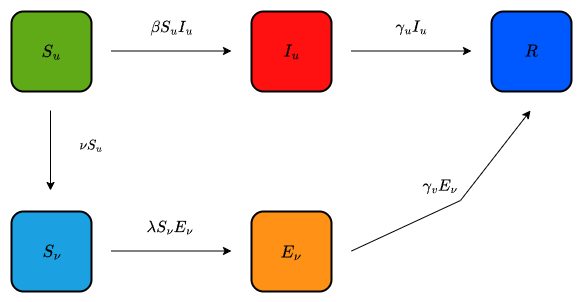

$$
\begin{aligned}
\frac{dS_u}{dt} &= -\beta S_u I_u - \nu S_u \\
\frac{dS_v}{dt} &= -\lambda S_v E_v + \nu S_u \\
\frac{dI_u}{dt} &= \beta S_u I_u - \gamma_u I_u \\
\frac{dE_v}{dt} &= \lambda S_v E_v - \gamma_v E_v \\
\frac{dR}{dt} &= \gamma_u I_u +  \gamma_v E_v
\end{aligned}
$$

Here, $\lambda$ is the **expose rate**, proportion of population exposed to the disease, assumed to be a constant for simplicity.

Initially:
$$
\begin{aligned}
S_u(0) &= (1-x_\nu) S \\
S_v(0) &= x_\nu S \\
I_u(0) &>= 1 person\\
E_v(0) &>= 1 person
\end{aligned}
$$

Here, $x_\nu$ is the **vaccinated proportion at t = 0**, assumed to be a constant for simplicity.


In [12]:
# Model 2 Definition
def sir_vacc_model2(y, t, pars):
    S_u = y[0]
    S_v = y[1]
    I_u = y[2]
    E_v = y[3]
    
    beta = pars['beta']
    nu = pars['v']
    lam = pars['lambda']
    gamma_u = pars['gamma_u']
    gamma_v = pars['gamma_v']

    dS_u = -beta * S_u * I_u - nu * S_u
    dS_v = -lam * S_v * E_v + nu * S_u
    dI_u = beta * S_u * I_u - gamma_u * I_u
    dE_v = lam * S_v * E_v - gamma_v * E_v
    dR = gamma_u * I_u + gamma_v * E_v

    dydt = [dS_u, dS_v, dI_u, dE_v, dR]
    return dydt

# Deterministic Simulations of Above Models + SIR Model

In [14]:
# Base SIR Model Definition
def sir_model(y, t, pars):
    S = y[0]
    I = y[1]
    
    dSdt = -pars['beta'] * S * I
    dIdt = pars['beta'] * S * I - pars['gamma'] * I
    dRdt = pars['gamma'] * I
    dydt = [dSdt, dIdt, dRdt]
    return dydt

In [15]:
def plot_base(beta, gamma, N=10009, I0=3, tf=100):
    pars={}
    pars['beta'] = beta # Transmission rate 
    pars['gamma'] = gamma # Recovery rate (1/days)
    pars['basR0'] = pars['beta'] / pars['gamma']
    pars['N'] = N
    pars['I0'] = I0
    pars['S0'] = pars['N'] - pars['I0']
    
    t = np.arange(0, tf)
    y = integrate.odeint(sir_model, np.array([pars['S0'], pars['I0'], 0]) / pars['N'], t, args = (pars,))

    plt.plot(t, y[:, 0], label='Susceptible', color='r')
    plt.plot(t, y[:, 1], label='Infectious', color='g')
    plt.plot(t, y[:, 2], label='Recovered', color='b')

    # I_peak = np.max(y[:, 1])
    # t_peak = t[np.argmax(y[:, 1])]
    # plt.plot(t_peak, I_peak, 'ro')
    # plt.text(t_peak + 1, I_peak, f'Peak\nDay {t_peak}\n{I_peak:.2%}', color='red')
    
    plt.xlabel( 'Time (days) ')
    plt.ylabel('Population proportion')
    plt.legend()
    plt.show()

In [16]:
def plot_vacc1(beta, gamma, v, N=1000, I0=10, tf=100):
    pars={}
    pars['beta'] = beta # Transmission rate 
    pars['gamma'] = gamma # Recovery rate (1/days)
    pars['v'] = v
    pars['N'] = N
    pars['I0'] = I0
    pars['S0'] = pars['N'] - pars['I0']
    
    t = np.arange(0, tf)
    y = integrate.odeint(sir_vacc_model1, np.array([pars['S0'], pars['I0'], 0]) / pars['N'], t, args = (pars,))

    plt.plot(t, y[:, 0], label='Susceptible_DT', color='r')
    plt.plot(t, y[:, 1], label='Infectious_DT', color='g')
    plt.plot(t, y[:, 2], label='Recovered_DT', color='b')

    I_peak = np.max(y[:, 1])
    t_peak = t[np.argmax(y[:, 1])]
    plt.plot(t_peak, I_peak, 'ro')
    plt.text(t_peak + 1, I_peak, f'Peak\nDay {t_peak}\n{I_peak:.2%}', color='red')
    
    plt.xlabel( 'Time (days) ')
    plt.ylabel('Population proportion')
    plt.legend()
    plt.show()

In [17]:
def plot_vacc1_1(beta, gamma, v, x_v, N=1000, I0=10, tf=100):
    pars={}
    pars['beta'] = beta # Transmission rate 
    pars['gamma'] = gamma # Recovery rate (1/days)
    pars['v'] = v
    pars['x_v'] = x_v
    pars['N'] = N
    pars['I0'] = I0
    pars['S0'] = pars['N'] - pars['I0']
    
    t = np.arange(0, tf)
    y = integrate.odeint(sir_vacc_model1_var, np.array([pars['S0'], pars['I0'], 0]) / pars['N'], t, args = (pars,))

    plt.plot(t, y[:, 0], label='Susceptible_DT', color='r')
    plt.plot(t, y[:, 1], label='Infectious_DT', color='g')
    plt.plot(t, y[:, 2], label='Recovered_DT', color='b')

    I_peak = np.max(y[:, 1])
    t_peak = t[np.argmax(y[:, 1])]
    plt.plot(t_peak, I_peak, 'ro')
    plt.text(t_peak + 1, I_peak, f'Peak\nDay {t_peak}\n{I_peak:.2%}', color='red')
    
    plt.xlabel( 'Time (days) ')
    plt.ylabel('Population proportion')
    plt.legend()
    plt.show()

In [18]:
def plot_vacc2(beta, lmbd, gamma_u, gamma_v, v, x_v, N=1000, I0=10, E0=10, tf=100):
    pars={}
    pars['beta'] = beta # Transmission rate 
    pars['gamma_u'] = gamma_u 
    pars['gamma_v'] = gamma_v 
    pars['v'] = v
    pars['lambda'] = lmbd
    pars['x_v'] = x_v
    pars['N'] = N
    pars['I0'] = I0
    pars['E0'] = E0
    pars['S0'] = pars['N'] - pars['I0'] - pars['E0']
    pars['Su_0'] = pars['S0'] * (1-pars['x_v'])
    pars['Sv_0'] = pars['S0'] = pars['Su_0']
    
    t = np.arange(0, tf)
    y = integrate.odeint(sir_vacc_model2, np.array([pars['Su_0'], pars['Sv_0'], pars['I0'], pars['E0'], 0]) / pars['N'], t, args = (pars,))

    plt.plot(t, y[:, 0], label='Susceptible_Unvacc', color='b')
    plt.plot(t, y[:, 1], label='Susceptible_Vacc', color='g')
    plt.plot(t, y[:, 2], label='Infectious', color='r')
    plt.plot(t, y[:, 3], label='Exposed', color='orange')
    plt.plot(t, y[:, 4], label='Recovered', color='gold')

    I_peak = np.max(y[:, 2])
    t_peak = t[np.argmax(y[:, 2])]
    plt.plot(t_peak, I_peak, 'ro')
    plt.text(t_peak + 1, I_peak, f'Peak\nDay {t_peak}\n{I_peak:.2%}', color='red')
    
    plt.xlabel( 'Time (days) ')
    plt.ylabel('Population proportion')
    plt.legend()
    plt.show()

In [19]:
interact(plot_base,
         beta=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='beta'),
         gamma=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='gamma'))

interactive(children=(FloatSlider(value=1.0, description='beta', max=10.0, min=0.1), FloatSlider(value=1.0, de…

<function __main__.plot_base(beta, gamma, N=10009, I0=3, tf=100)>

In [20]:
interact(plot_vacc1,
         beta=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='beta'),
         gamma=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='gamma'),
         v=FloatSlider(min=0.01, max=1, step=0.01, value=0.05, description='vaccination rate'))

interactive(children=(FloatSlider(value=1.0, description='beta', max=10.0, min=0.1), FloatSlider(value=1.0, de…

<function __main__.plot_vacc1(beta, gamma, v, N=1000, I0=10, tf=100)>

In [21]:
interact(plot_vacc1_1,
         beta=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='beta'),
         gamma=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='gamma'),
         v=FloatSlider(min=0.01, max=1, step=0.01, value=0.05, description='vaccination rate'),
         x_v=FloatSlider(min=0.01, max=1, step=0.01, value=0.7, description='vaccination accessible population proportion'))

interactive(children=(FloatSlider(value=1.0, description='beta', max=10.0, min=0.1), FloatSlider(value=1.0, de…

<function __main__.plot_vacc1_1(beta, gamma, v, x_v, N=1000, I0=10, tf=100)>

In [22]:
interact(plot_vacc2,
         beta=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='beta'),
         lmbd=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='expose rate'),
         gamma_u=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='gamma_u'),
         gamma_v=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='gamma_v'),
         v=FloatSlider(min=0.01, max=1, step=0.01, value=0.05, description='vaccination rate'),
         x_v=FloatSlider(min=0.01, max=1, step=0.01, value=0.7, description='initial vaccinated proportion'))

interactive(children=(FloatSlider(value=1.0, description='beta', max=10.0, min=0.1), FloatSlider(value=1.0, de…

<function __main__.plot_vacc2(beta, lmbd, gamma_u, gamma_v, v, x_v, N=1000, I0=10, E0=10, tf=100)>

# Other Model Suggestions

## Model 2 - Variant

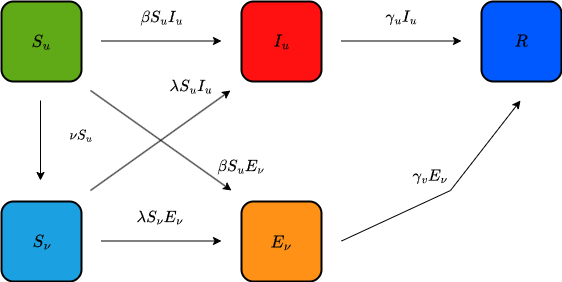

# Stochastic Simulation

- #### Considered simplest model, model 1.
- #### Used Standard Gillespie Algorithm
    - Note: Parson's paper's simulation used Tau-leaping approximation (adaptiveTau R package) strategy here, considering tremendous amount of time repeating simulation for 10^5 times.
    - Instead, we provide framework for finding simulation repetition time and optimal parameter space for optimal simulation time and accuracy.

In [26]:
def stochsim_SIR(y0, trange, pars, seed):
    np.random.seed(seed)
    t0 = trange[0] # Start Time Frame = 0
    tf = trange[1] # End Time Frame
    t = [t0]
    y = [y0]       # y is list of [S, I, R], and each elements indicate compartment population proportion at corresponding time.
    tcur = t0
    ycur = list(y0)
    ind = 0

    # Escape loop when 
    # - End Time Frame is reached 
    # - No Infectious individuals
    while tcur<tf:
        
        if ycur[1]==0:
            ind = ind+1
            t.append(tf)
            y.append(ycur)
            break
            
        # Rates
        infrate = pars['beta']*ycur[0]*ycur[1]/pars['N']  # Infection event rate : beta * S * I / N
        recrate = pars['gamma']*ycur[1]                   # Recover event rate : gamma * I
        
        totrate = infrate + recrate
        dt = -1/totrate * np.log(np.random.uniform())     # draw time step to next time from exponential distribution with mean 1/total_event_rate
        tcur = tcur + dt
        
        # An event determined randomly each of events' selection prob. of the event rate / total event rate
        if np.random.uniform() < (infrate/totrate) :                           # Infection
            ycur[0] = ycur[0] - 1
            ycur[1] = ycur[1] + 1
        else:                                                                  # Recovery
            ycur[1] = ycur[1] - 1
            ycur[2] = ycur[2] + 1
        ind = ind + 1
        t.append(tcur) 
        y.append(list(ycur))
        
    y = np.array(y)
    return [t, y]

In [27]:
def stochsim_SIR_vacc(y0, trange, pars, seed):
    np.random.seed(seed)
    t0 = trange[0] # Start Time Frame = 0
    tf = trange[1] # End Time Frame
    t = [t0]
    y = [y0]       # y is list of [S, I, R], and each elements indicate compartment population proportion at corresponding time.
    tcur = t0
    ycur = list(y0)
    ind = 0

    # Escape loop when 
    # - End Time Frame is reached 
    # - No Infectious individuals
    while tcur<tf:
        
        if ycur[1]==0:
            ind = ind+1
            t.append(tf)
            y.append(ycur)
            break
            
        # Rates
        infrate = pars['beta']*ycur[0]*ycur[1]/pars['N']  # Infection event rate : beta * S * I / N
        recrate = pars['gamma']*ycur[1]                   # Recover event rate : gamma * I
        vacrate = pars['v']* ycur[0]                      # Vaccination event rate : v * S
        
        totrate = infrate + recrate + vacrate
        dt = -1/totrate * np.log(np.random.uniform())     # draw time step to next time from exponential distribution with mean 1/total_event_rate
        tcur = tcur + dt
        
        # An event determined randomly each of events' selection prob. of the event rate / total event rate
        uniform = np.random.uniform()
        if uniform < (infrate/totrate) :                           # Infection
            ycur[0] = ycur[0] - 1
            ycur[1] = ycur[1] + 1
        elif uniform < (infrate/totrate) + (vacrate/totrate) :     # Vaccination ( S = S - 1 and R = R + 1 )
            ycur[0] = ycur[0] - 1
            ycur[2] = ycur[2] + 1
        else:                                                                  # Recovery
            ycur[1] = ycur[1] - 1
            ycur[2] = ycur[2] + 1
        ind = ind + 1
        t.append(tcur) 
        y.append(list(ycur))
        
    y = np.array(y)
    return [t, y]

In [68]:
def plot_stochastic_epioutcomes(beta, gamma, nu, N=10000, I0=1, tf=100, nsim=10, seed_adj=0, vacc=True, logsc=False):
    
    pars = {}
    pars['beta'] = beta 
    pars['gamma'] = gamma
    pars['v'] = nu

    pars['N'] = N
    pars['I0'] = I0
    pars['S0'] = pars['N'] - pars['I0']

    times = []
    ivals = []
    
    t = np.arange(0, tf)
    if vacc == False:
        y = integrate.odeint(sir_model, np.array([pars['S0'], pars['I0'], 0]) / pars['N'], t, args = (pars,))
    else :
        y = integrate.odeint(sir_vacc_model1, np.array([pars['S0'], pars['I0'], 0]) / pars['N'], t, args = (pars,))

    plt.plot(t, y[:, 0]*pars['N'], label='S Deterministic', color='r')
    plt.plot(t, y[:, 1]*pars['N'], label='I Deterministic', color='g')
    plt.plot(t, y[:, 2]*pars['N'], label='R Deterministic', color='b')
        
    plt.plot(0, 0, alpha=0.3, color='r', linestyle='dashed', label='S Stochastic')
    plt.plot(0, 0, alpha=0.3, color='g', linestyle='dashed', label='I Stochastic')
    plt.plot(0, 0, alpha=0.3, color='b', linestyle='dashed', label='R Stochastic')
    
    for i in range(0, nsim):
        if vacc == False:
            [tst, yst] = stochsim_SIR([pars['S0'], pars['I0'], 0], [0, tf], pars, seed=i+seed_adj)
        else :
            [tst, yst] = stochsim_SIR_vacc([pars['S0'], pars['I0'], 0], [0, tf], pars, seed=i+seed_adj)

        plt.plot(tst, yst[:, 0], alpha=0.3, color='r', linestyle='dashed')
        plt.plot(tst, yst[:, 1], alpha=0.3, color='g', linestyle='dashed')
        plt.plot(tst, yst[:, 2], alpha=0.3, color='b', linestyle='dashed')

        times.append(tst)
        ivals.append(yst[:, 1])
    
    plt.xlabel('Time (in days)')
    plt.ylabel('Population (in person)')
    if vacc:
        plt.title('Epi Outcomes in SIR Model with Vaccination')
    else :
        plt.title('Epi Outcomes in SIR Model')
        
    plt.legend()
    plt.grid(True)

    return times, ivals

In [120]:
def plot_stochastic_infectious_focused(beta, gamma, nu, N=10000, I0=1, tf=100, nsim=10, seed_adj=0, vacc=True, logsc=False):
    fig, ax = plt.subplots()

    pars = {}
    pars['beta'] = beta 
    pars['gamma'] = gamma
    pars['v'] = nu

    pars['N'] = N
    pars['I0'] = I0
    pars['S0'] = pars['N'] - pars['I0']

    times = []
    ivals = []
    
    t = np.arange(0, tf)
    if vacc == False:
        y = integrate.odeint(sir_model, np.array([pars['S0'], pars['I0'], 0]) / pars['N'], t, args = (pars,))
    else :
        y = integrate.odeint(sir_vacc_model1, np.array([pars['S0'], pars['I0'], 0]) / pars['N'], t, args = (pars,))

    if logsc:
        yi = np.log10(np.maximum(y[:, 1]*pars['N'], 0))
    else:
        yi = y[:,1]*pars['N']
            
    plt.plot(t, yi, label='I Deterministic', color='r')
    plt.plot(0, 0, alpha=0.3, color='black', linestyle='dashed', label='I Stochastic BURNOUT')
    plt.plot(0, 0, alpha=0.3, color='blue', linestyle='dashed', label='I Stochastic FIZZLE')
    
    for i in range(0, nsim):
        if vacc == False:
            [tst, yst] = stochsim_SIR([pars['S0'], pars['I0'], 0], [0, tf], pars, seed=i+seed_adj)
        else:
            [tst, yst] = stochsim_SIR_vacc([pars['S0'], pars['I0'], 0], [0, tf], pars, seed=i+seed_adj)
        
        x = 20  # Should be Modified Manually
        idx = bisect.bisect_right(yst[:,1], x)
        beginning = yst[:,1][:idx]

        if logsc:
            ysti = np.log10(np.maximum(yst[:, 1], 0))
        else:
            ysti = yst[:,1]

        if beginning[-1] == 0: 
            plt.plot(tst, ysti, alpha=0.3, color='b', linestyle='dashed')
        else:
            plt.plot(tst, ysti, alpha=0.3, color='black', linestyle='dashed')
            
        times.append(tst)
        ivals.append(yst[:, 1])
    
    plt.xlabel('Time (in days)')
    if logsc:
        plt.ylabel('Log(Infectious Population) (in person)')
    else:
        plt.ylabel('Infectious Population (in person)')

        
    if vacc:
        plt.title('Epi Outcomes in SIR Model')
    else:
        plt.title('Epi Outcomes in SIR Model')

    if logsc:
        ax.yaxis.set_major_formatter(FuncFormatter(log_formatter))
    plt.legend()
    plt.grid(True)

    return times, ivals

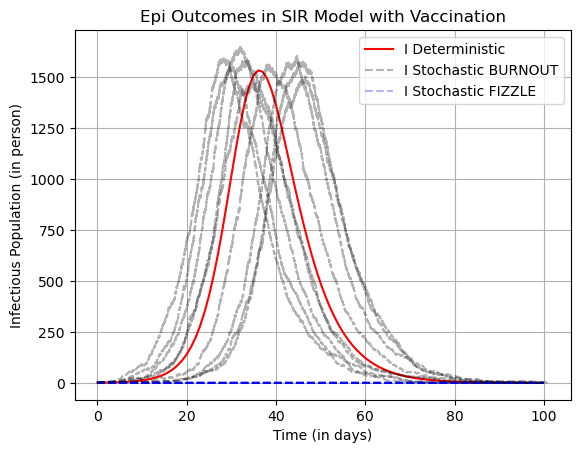

In [136]:
times, ivals = plot_stochastic_infectious_focused(0.5, 0.25, 0, nsim = 20, seed_adj=0, vacc = True, logsc=False)

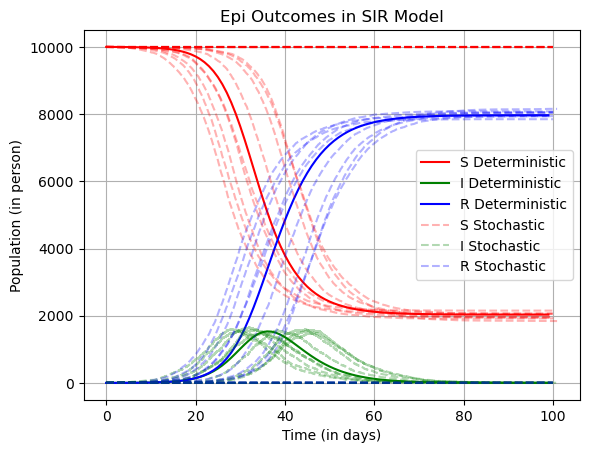

In [73]:
times, ivals = plot_stochastic_epioutcomes(0.5, 0.25, 0.1, nsim = 20, seed_adj=0, vacc = False)

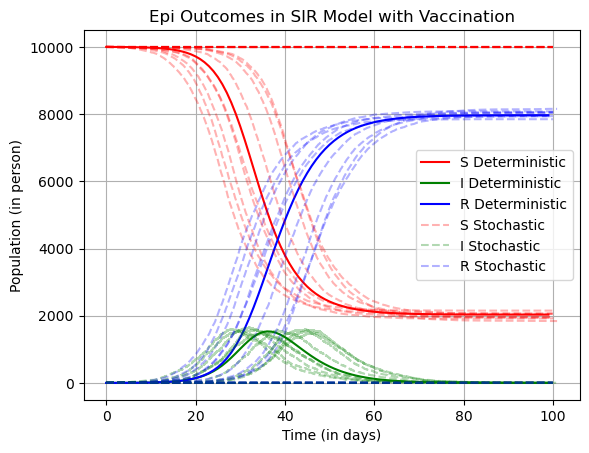

In [130]:
times, ivals = plot_stochastic_epioutcomes(0.5, 0.25, 0, nsim = 20, seed_adj=0, vacc =True)

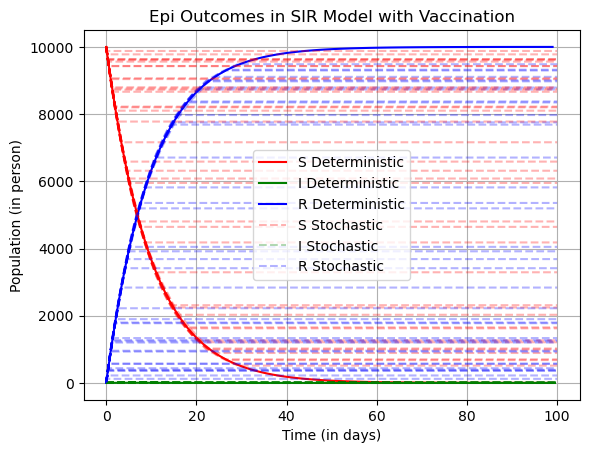

In [33]:
times, ivals = plot_stochastic_epioutcomes(1, 0.5, 0.1, nsim = 40, seed_adj = 0)

In [34]:
lst =[1, 2, 3, 4, 5]
lst[-1]

5

## Notes

Modify values by parameter slide sometimes break the plots, have to restrict some parameter sets.